### Welcome ! This model predicts Backpack Prices 
Let's see what we have got in our directory and I am doing it locally so I should check few things 

In [55]:
import os
import pandas as pd 
os.listdir('../dataset')

['sample_submission.csv', 'test.csv', 'train.csv', 'training_extra.csv']

Let's import some libraries 

In [56]:
import sklearn
import lightgbm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [57]:
print(np.__version__)
print(pd.__version__)
print(sklearn.__version__)
print(lightgbm.__version__)



2.2.5
2.2.3
1.6.1
4.6.0


In [3]:
!pip freeze > requirements.txt


#### Data Loading 

In [58]:
import pandas as pd 
train = pd.read_csv('../dataset/train.csv',index_col='id')
test = pd.read_csv('../dataset/test.csv',index_col='id')
train_extra = pd.read_csv('../dataset/training_extra.csv',index_col='id')

All right , we can see shape of datasets and few columns in order to understand the data we have

In [59]:
print('Train shape:',train.shape)
print('Test shape:',test.shape)
print('Train extra shape:',train_extra.shape)

Train shape: (300000, 10)
Test shape: (200000, 9)
Train extra shape: (3694318, 10)


We have quite a big dataset here

In [60]:
# Let's see head of three datasets 
print("\nTrain Dataset:")
display(train.head())
print("\nTest Dataset:")
display(test.head())
print("\nTrain Extra Dataset:")
display(train_extra.head())


Train Dataset:


Brand Material    Size  Compartments Laptop Compartment Waterproof  \
id                                                                              
0       Jansport  Leather  Medium           7.0                Yes         No   
1       Jansport   Canvas   Small          10.0                Yes        Yes   
2   Under Armour  Leather   Small           2.0                Yes         No   
3           Nike    Nylon   Small           8.0                Yes         No   
4         Adidas   Canvas  Medium           1.0                Yes        Yes   

        Style  Color  Weight Capacity (kg)      Price  
id                                                     
0        Tote  Black             11.611723  112.15875  
1   Messenger  Green             27.078537   68.88056  
2   Messenger    Red             16.643760   39.17320  
3   Messenger  Green             12.937220   80.60793  
4   Messenger  Green             17.749338   86.02312


Test Dataset:


Brand Material    Size  Compartments Laptop Compartment Waterproof  \
id                                                                            
300000    Puma  Leather   Small           2.0                 No         No   
300001    Nike   Canvas  Medium           7.0                 No        Yes   
300002  Adidas   Canvas   Large           9.0                 No        Yes   
300003  Adidas    Nylon   Large           1.0                Yes         No   
300004     NaN    Nylon   Large           2.0                Yes        Yes   

            Style  Color  Weight Capacity (kg)  
id                                              
300000       Tote  Green             20.671147  
300001   Backpack  Green             13.564105  
300002  Messenger   Blue             11.809799  
300003  Messenger  Green             18.477036  
300004       Tote  Black              9.907953


Train Extra Dataset:


Brand   Material   Size  Compartments Laptop Compartment  \
id                                                                        
500000  Under Armour     Canvas  Small          10.0                Yes   
500001          Puma  Polyester  Small           4.0                 No   
500002      Jansport  Polyester  Small           8.0                Yes   
500003          Nike      Nylon  Large           7.0                 No   
500004          Nike    Leather  Large           9.0                 No   

       Waterproof      Style  Color  Weight Capacity (kg)      Price  
id                                                                    
500000        Yes       Tote   Blue             23.882052  114.11068  
500001        Yes   Backpack  Green             11.869095  129.74972  
500002        Yes       Tote    Red              8.092302   21.37370  
500003         No  Messenger   Pink              7.719581   48.09209  
500004        Yes       Tote  Green             22.741826   77.32461

### Let's do some EDA (Exploratory Data Analysis)

#### Price Distribution for Train and Train extra

Price Distributions in Train and Train_extra Datasets


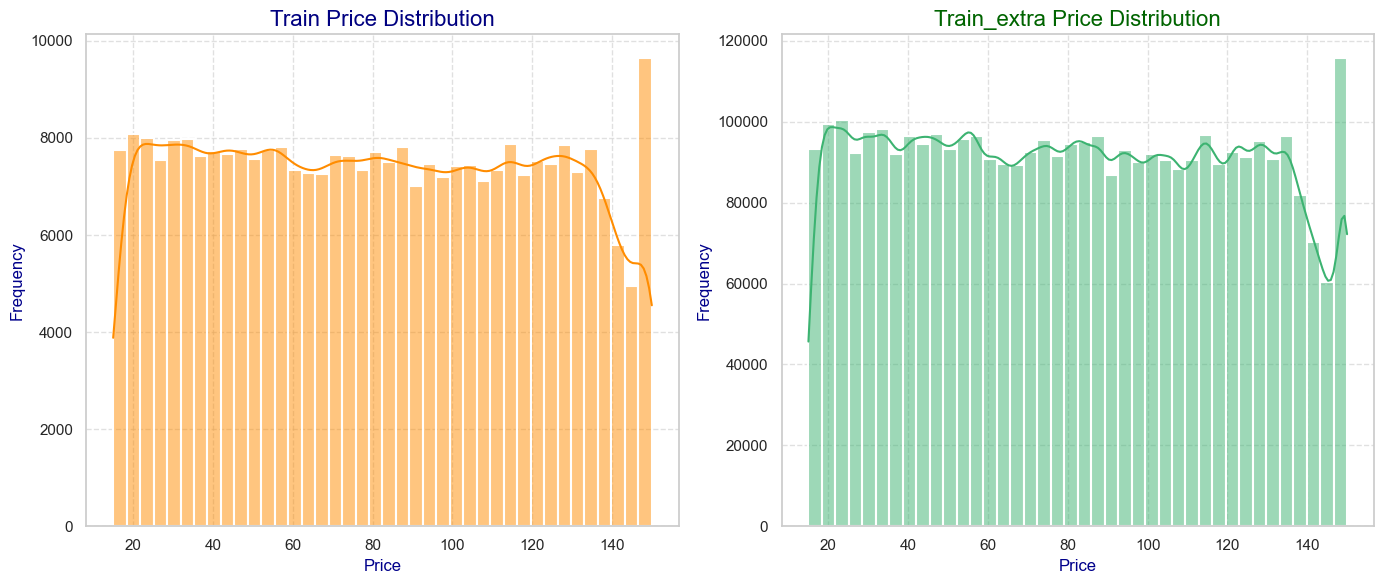

In [61]:
#Let's see Price distribution in Train and Train Extra datasets
print("Price Distributions in Train and Train_extra Datasets")
plt.figure(figsize=(14, 6))

# first subplot 
plt.subplot(1, 2, 1)
sns.histplot(train['Price'], bins=40, kde=True, color='darkorange', linewidth=1.5)
plt.title("Train Price Distribution", fontsize=16, color='navy')
plt.xlabel("Price", fontsize=12, color='darkblue')
plt.ylabel("Frequency", fontsize=12, color='darkblue')
plt.grid(True, linestyle='--', alpha=0.6)

# second subplot 
plt.subplot(1, 2, 2)
sns.histplot(train_extra['Price'], bins=40, kde=True, color='mediumseagreen', linewidth=1.5)
plt.title("Train_extra Price Distribution", fontsize=16, color='darkgreen')
plt.xlabel("Price", fontsize=12, color='darkblue')
plt.ylabel("Frequency", fontsize=12, color='darkblue')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#### Numeric columns distribution for Train/Test/Train_extra

Let's see Numeric types for Train, Test, and Train_extra Datasets


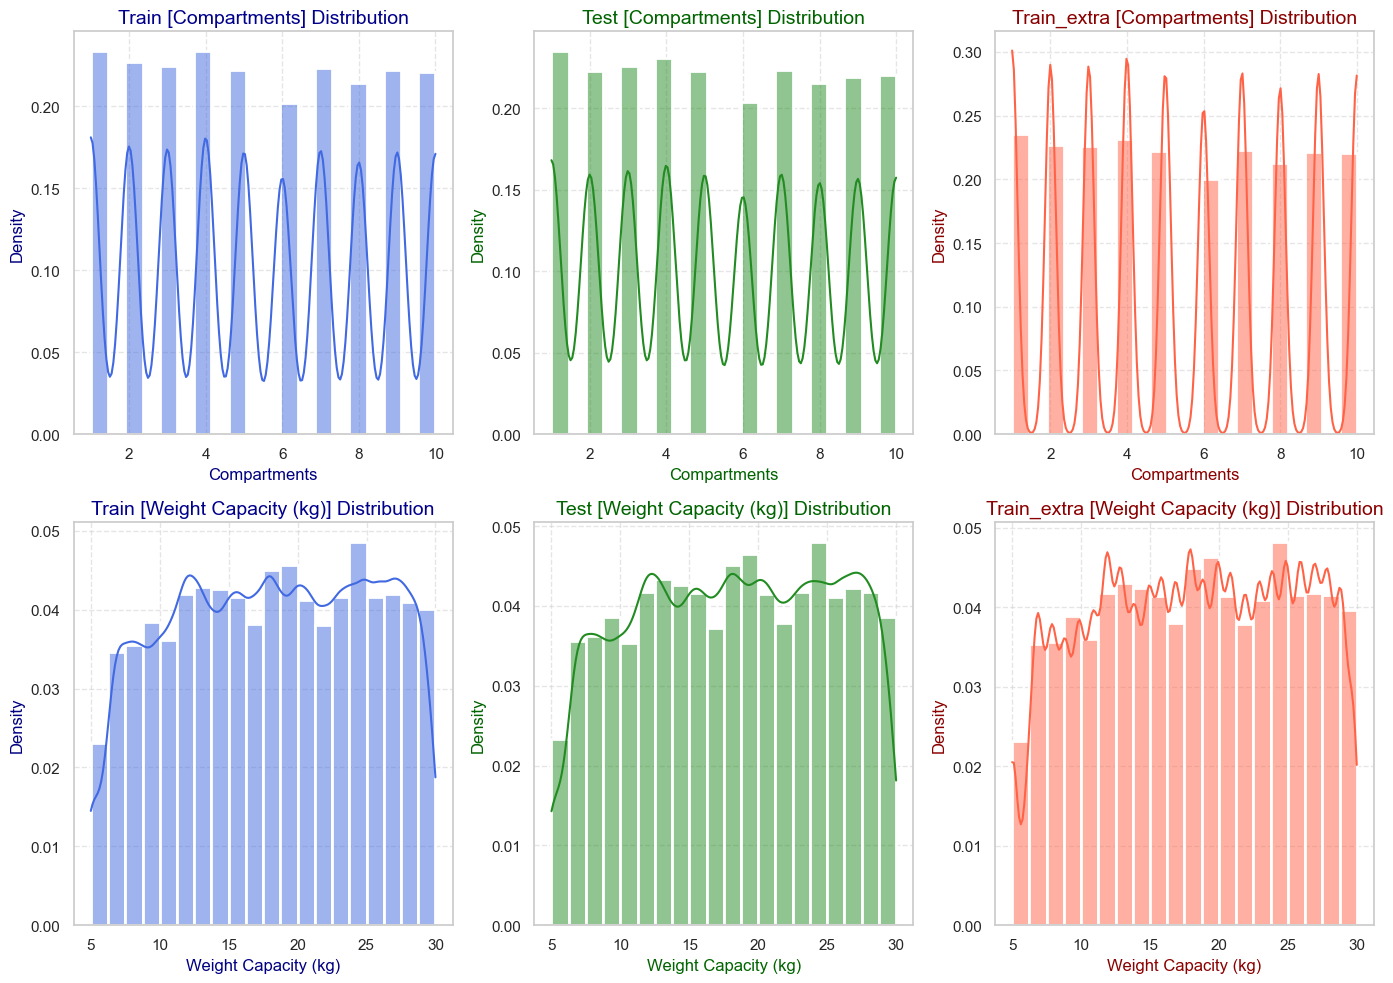

In [62]:
#We first see numeric columns ditribution then we will jump categorical columns
print("Let's see Numeric types for Train, Test, and Train_extra Datasets")
num_cols = test.select_dtypes(include=['number']).columns
plt.figure(figsize=(14, len(num_cols) * 5))

# we will loop through each numeric column and create subplots
for i, col in enumerate(num_cols):
    # Train Dataset Distribution
    plt.subplot(len(num_cols), 3, i*3 + 1)
    sns.histplot(train[col], bins=20, kde=True, color='royalblue', linewidth=2, stat='density')
    plt.title(f"Train [{col}] Distribution", fontsize=14, color='darkblue')
    plt.xlabel(col, fontsize=12, color='navy')
    plt.ylabel('Density', fontsize=12, color='navy')
    plt.grid(True, linestyle='--', alpha=0.5)

    # Test Dataset Distribution
    plt.subplot(len(num_cols), 3, i*3 + 2)
    sns.histplot(test[col], bins=20, kde=True, color='forestgreen', linewidth=2, stat='density')
    plt.title(f"Test [{col}] Distribution", fontsize=14, color='darkgreen')
    plt.xlabel(col, fontsize=12, color='darkgreen')
    plt.ylabel('Density', fontsize=12, color='darkgreen')
    plt.grid(True, linestyle='--', alpha=0.5)

    # Train_extra Dataset Distribution
    plt.subplot(len(num_cols), 3, i*3 + 3)
    sns.histplot(train_extra[col], bins=20, kde=True, color='tomato', linewidth=2, stat='density')
    plt.title(f"Train_extra [{col}] Distribution", fontsize=14, color='darkred')
    plt.xlabel(col, fontsize=12, color='darkred')
    plt.ylabel('Density', fontsize=12, color='darkred')
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### Categorical columns distribution for Train/Test/Train_extra

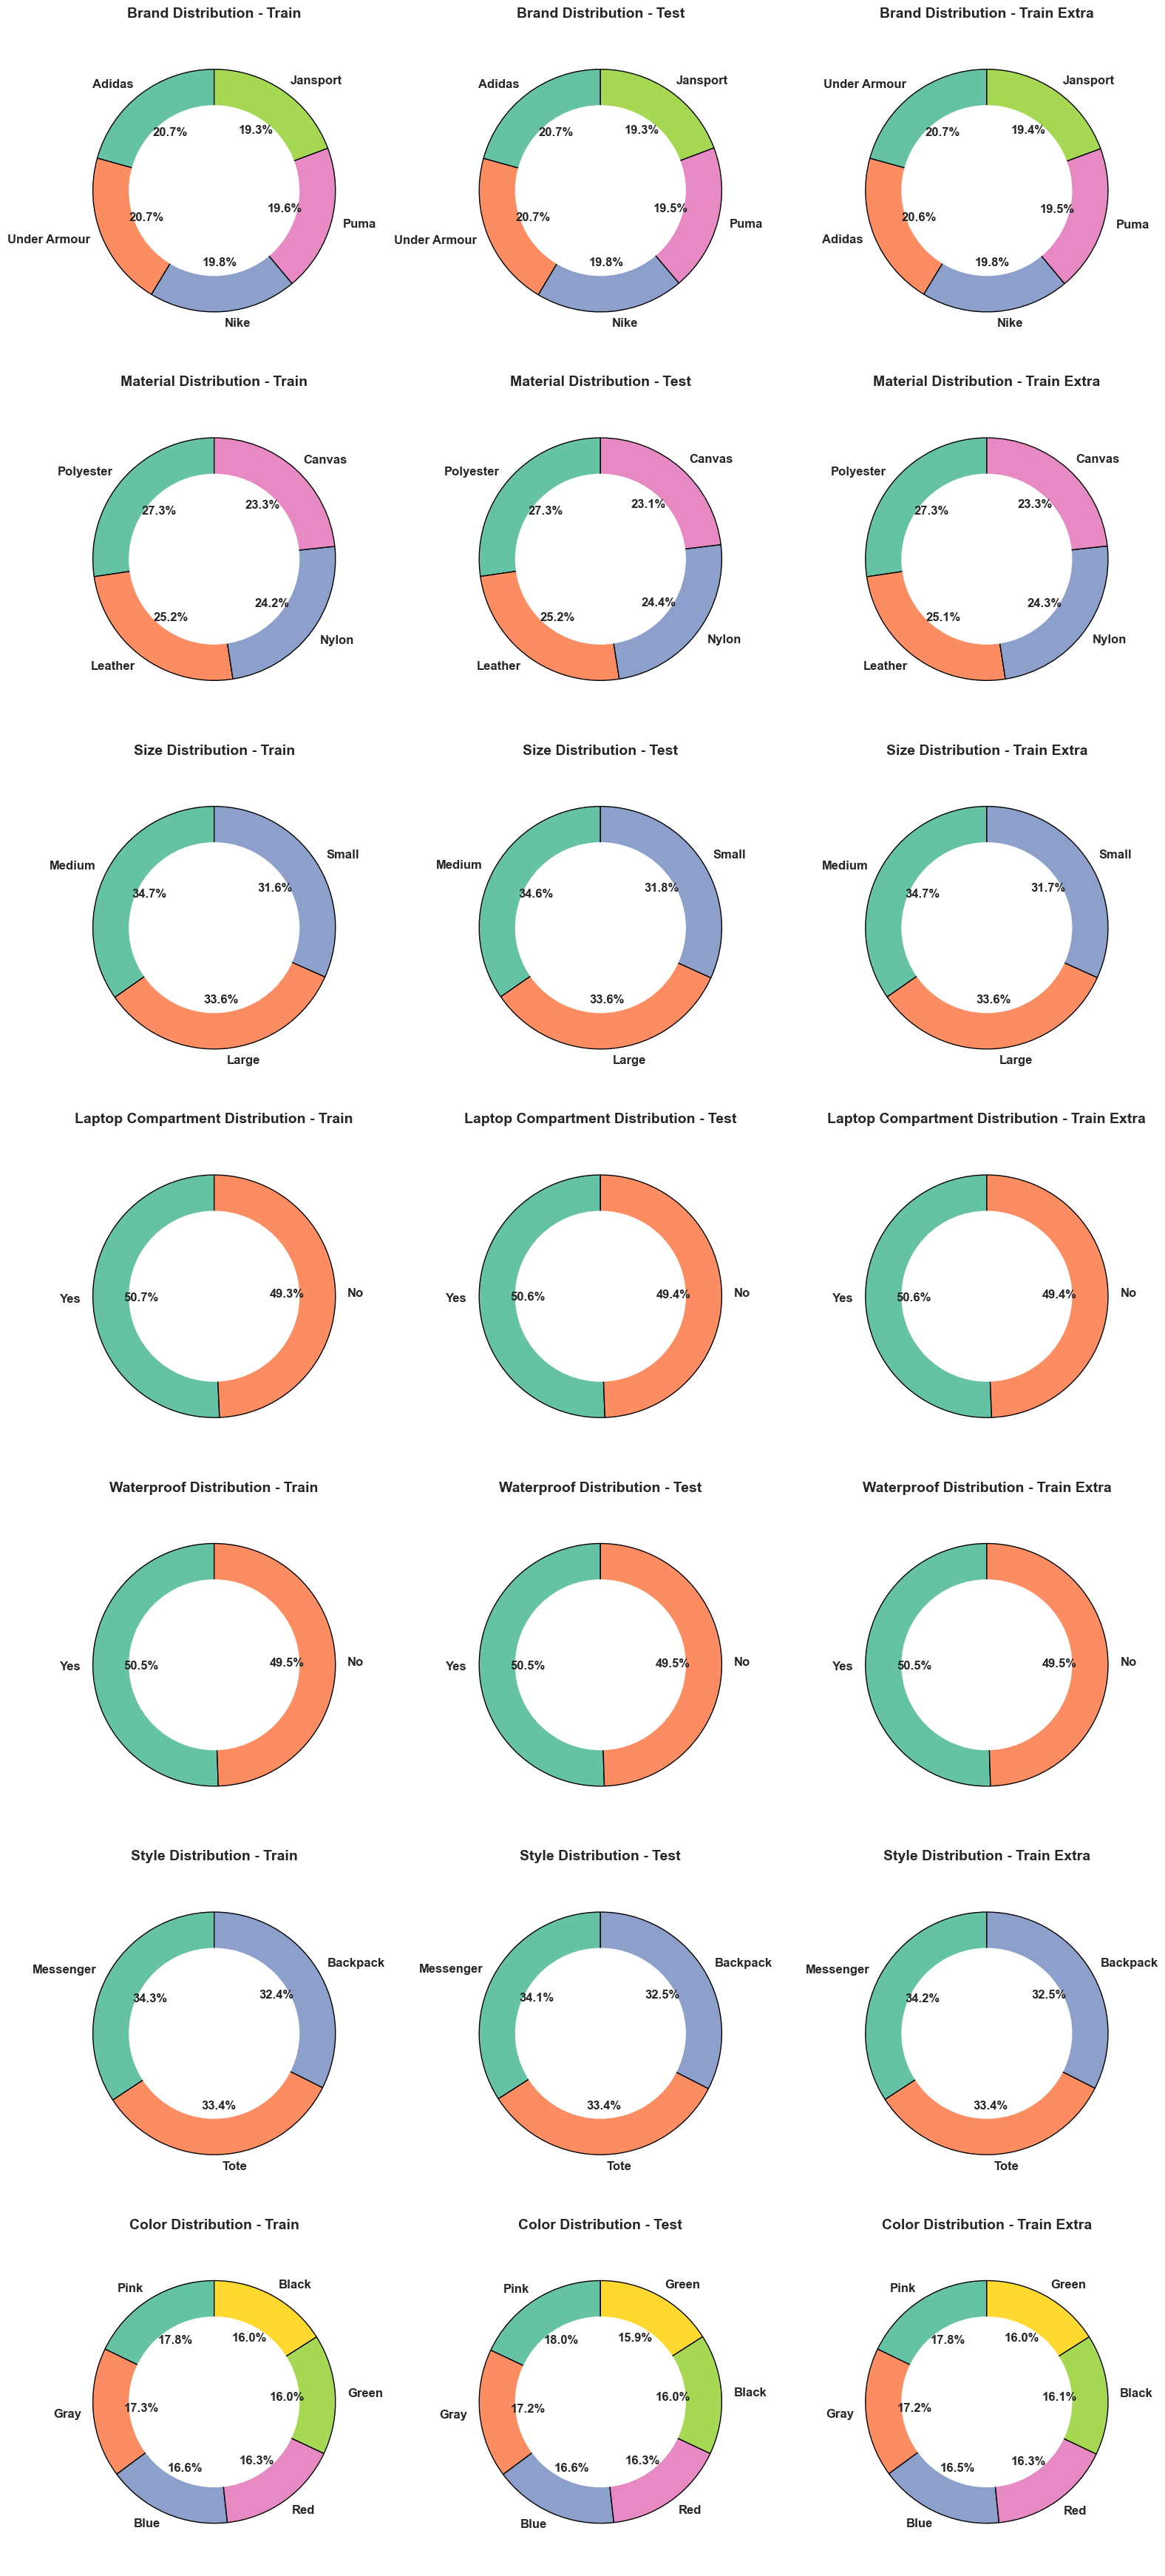

In [63]:
#Now let's plot categorical columns
categorical_columns_train = train.select_dtypes(include=['object']).columns.tolist()
def plot_categorical_distributions_grid(cat_columns, datasets, titles):
    num_features = len(cat_columns)
    num_datasets = len(datasets)

    # grid of subplots with one row for each feature and one column for each dataset
    fig, axes = plt.subplots(num_features, num_datasets, figsize=(16, 5 * num_features))
    custom_palette = sns.color_palette("Set2", 8)  # Set2 palette provides a wide range of colors
    for i, col in enumerate(cat_columns):
        for j, (data, title) in enumerate(zip(datasets, titles)):
            # Get value counts for the current categorical column
            counts = data[col].value_counts()

            # Plot pie chart for the current dataset and column
            wedges, texts, autotexts = axes[i, j].pie(
                counts,
                labels=counts.index,
                autopct='%1.1f%%', 
                startangle=90,
                colors=custom_palette[:len(counts)],
                wedgeprops={'edgecolor': 'black', 'linewidth': 1}  
            )

            # Add a circle at the center to create a donut-like pie chart
            centre_circle = plt.Circle((0, 0), 0.70, fc='white')
            axes[i, j].add_artist(centre_circle)

            # Set title, font properties and make sure pie chart is a circle
            axes[i, j].set_title(f'{col} Distribution - {title}', fontsize=14, fontweight='bold')
            axes[i, j].axis('equal')  
            # Customize the font for the labels and percentages
            for text in texts + autotexts:
                text.set_fontsize(12)
                text.set_fontweight('bold')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage with datasets and titles
datasets = [train, test, train_extra]
titles = ['Train', 'Test', 'Train Extra']

# Assuming cat_columns_train contains the list of categorical column names
plot_categorical_distributions_grid(categorical_columns_train, datasets, titles)


#### Comparison of the number categorical features accross all datasets

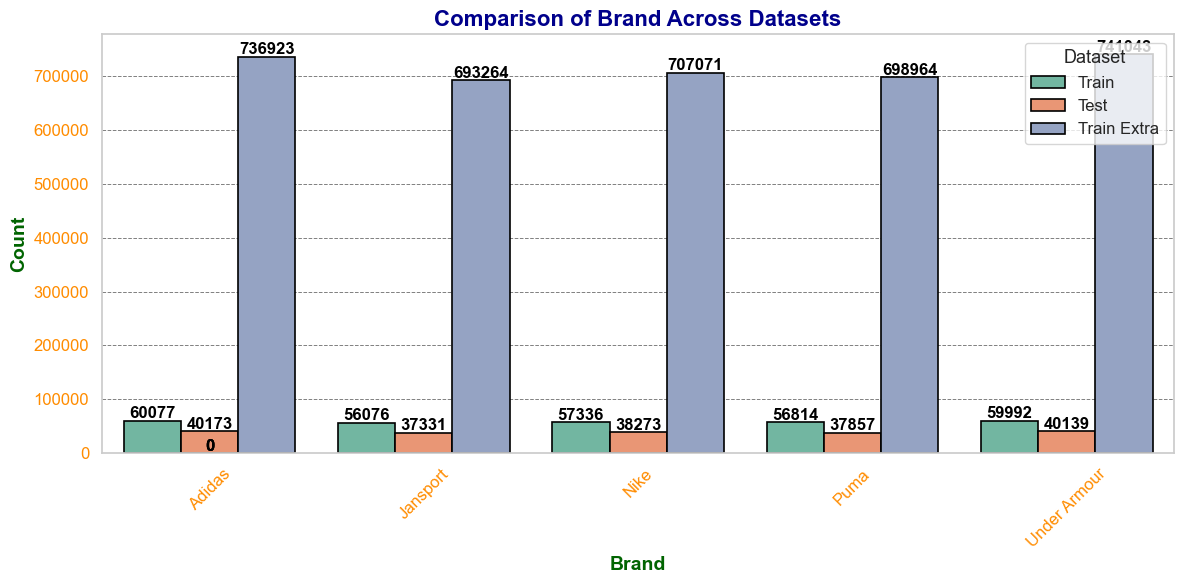

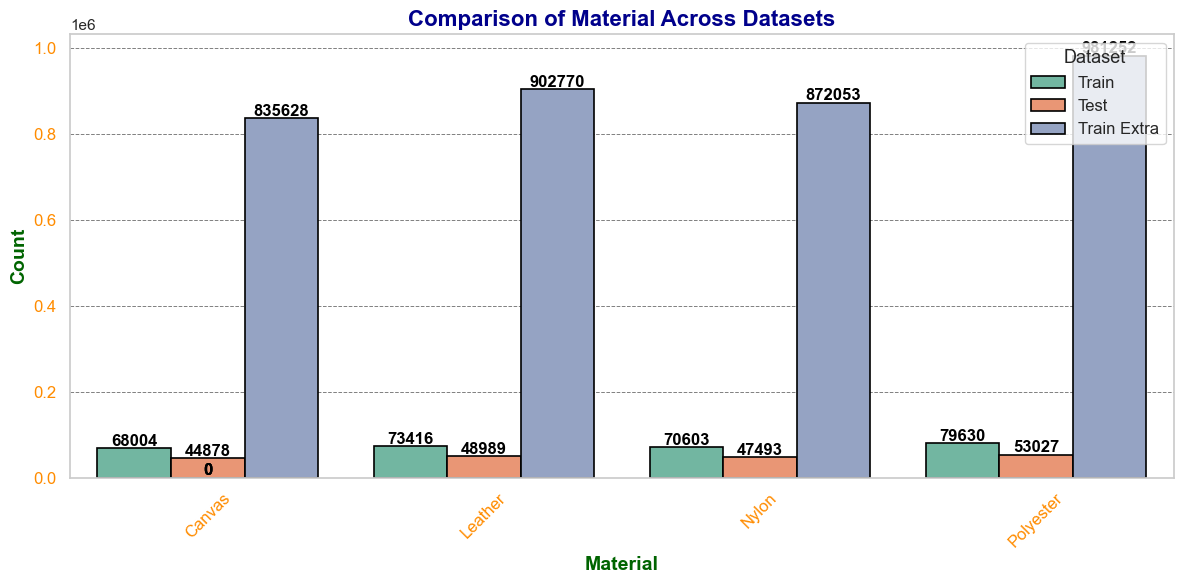

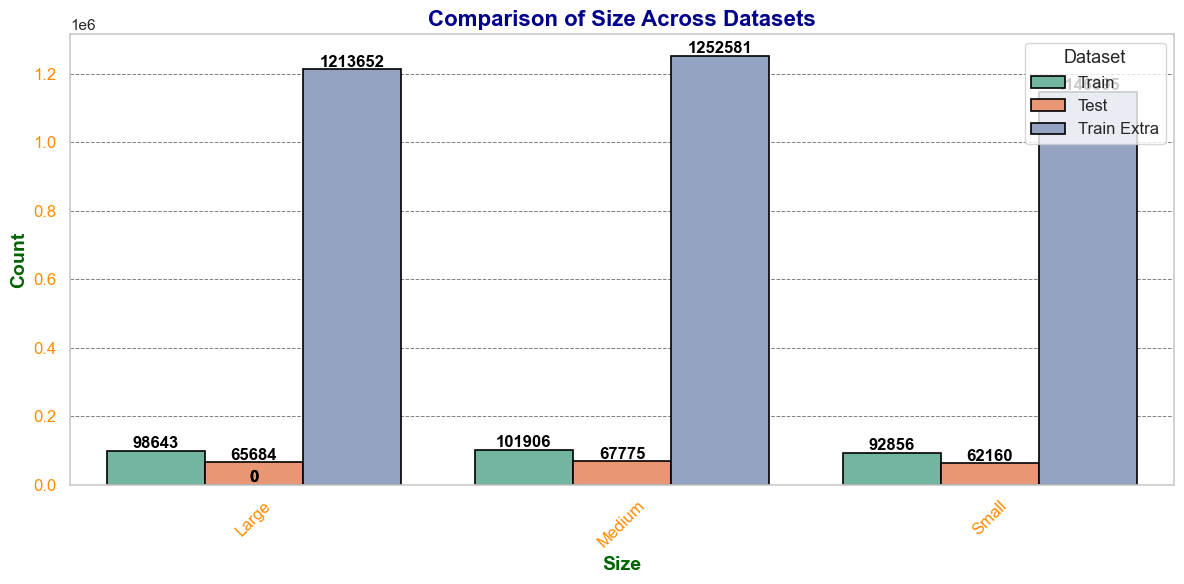

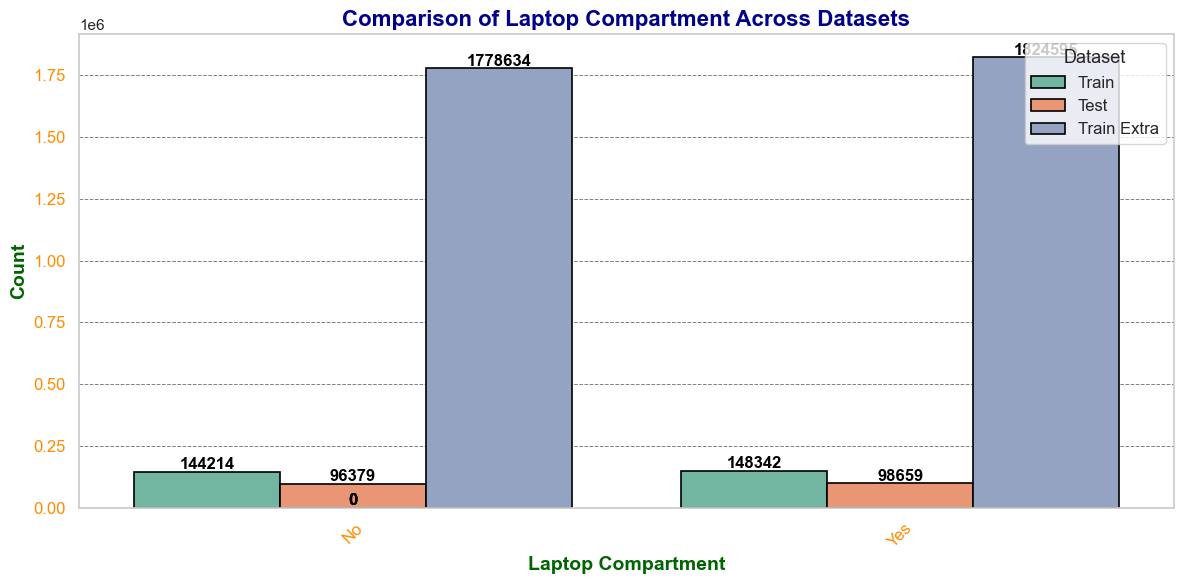

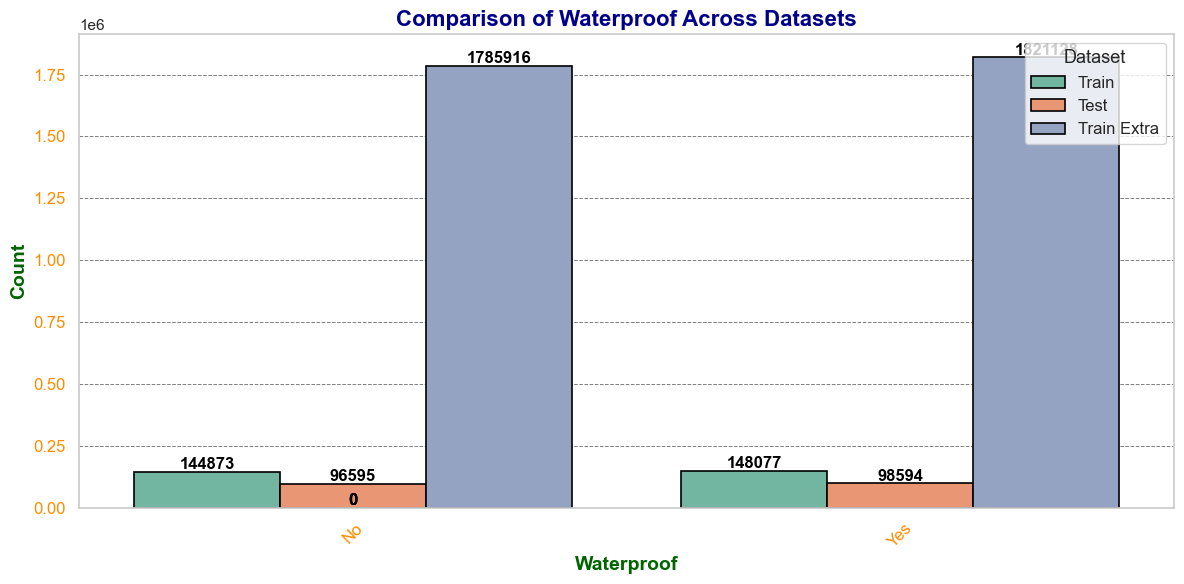

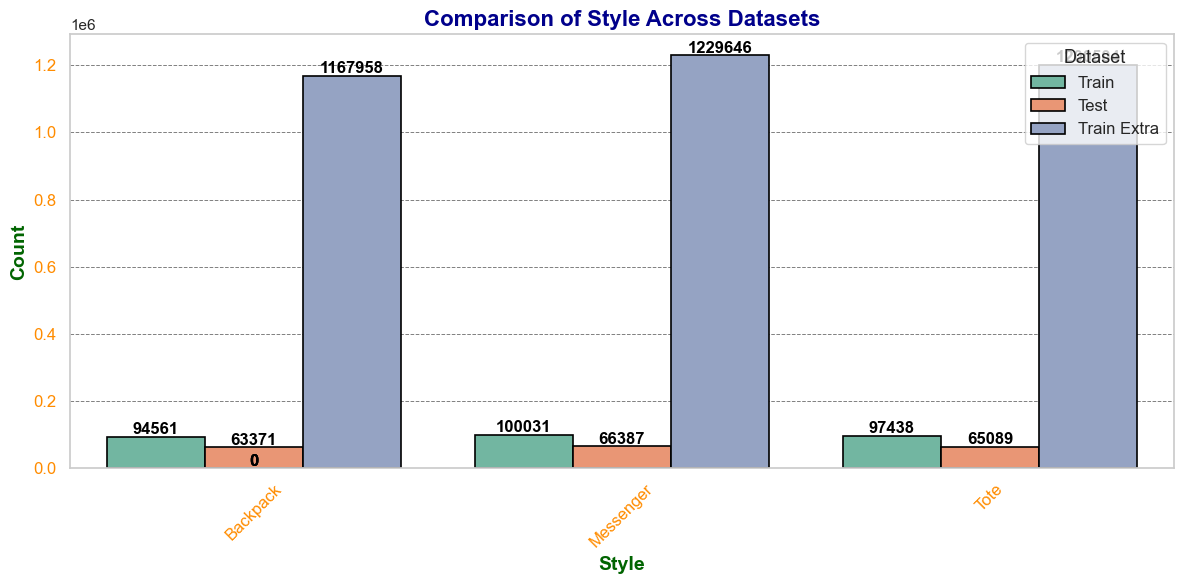

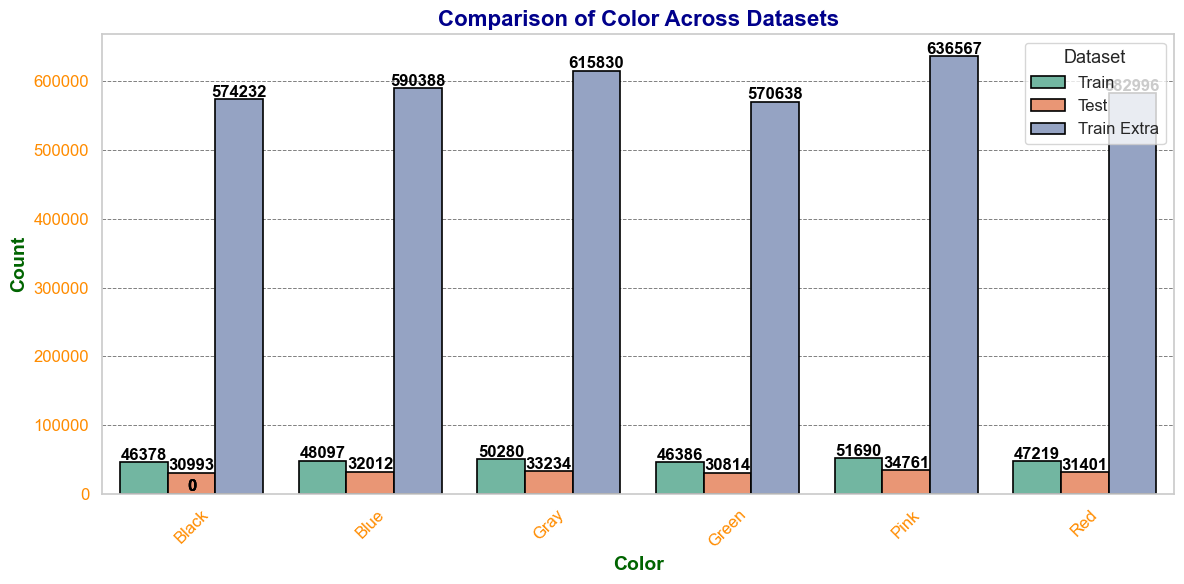

In [64]:
def plot_grouped_bar(data1, data2, data3, cat_columns):
    sns.set(style="whitegrid", palette="Set2") 
    
    for col in cat_columns:
        plt.figure(figsize=(12, 6))

        # Count occurrences in each dataset
        count_train = data1[col].value_counts().reset_index()
        count_train.columns = [col, 'Train']
        
        count_test = data2[col].value_counts().reset_index()
        count_test.columns = [col, 'Test']
        
        count_train_ex = data3[col].value_counts().reset_index()
        count_train_ex.columns = [col, 'Train Extra']
        
        # Merge counts into a single DataFrame
        merged_counts = count_train.merge(count_test, on=col, how='outer').merge(count_train_ex, on=col, how='outer').fillna(0)
        
        # Melt the DataFrame for easier plotting
        melted_counts = merged_counts.melt(id_vars=col, var_name='Dataset', value_name='Count')

        # Create a custom bar plot with a wider and more distinct style
        ax = sns.barplot(data=melted_counts, x=col, y='Count', hue='Dataset', palette="Set2", edgecolor="black", linewidth=1.2)
        
        # Add annotations on top of the bars with improved style
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 5), textcoords='offset points',
                        fontsize=12, fontweight='bold', color='black')

        plt.title(f'Comparison of {col} Across Datasets', fontsize=16, fontweight='bold', color='darkblue')
        plt.xlabel(col, fontsize=14, fontweight='bold', color='darkgreen')
        plt.ylabel('Count', fontsize=14, fontweight='bold', color='darkgreen')
        plt.xticks(rotation=45, fontsize=12, fontweight='light', color='darkorange')
        plt.yticks(fontsize=12, fontweight='light', color='darkorange')
        # legend
        plt.legend(title='Dataset', fontsize=12, title_fontsize='13', loc='upper right')
        plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.7)
        # Adjust layout for better spacing
        plt.tight_layout()
        plt.show()
plot_grouped_bar(train, test, train_extra, categorical_columns_train)


#### BRAND VS STYLE Distribution

In [65]:
import plotly.express as px
df = train.groupby(['Brand', 'Style']).size().reset_index(name='Count')

# Use the same distinct color palette as the grouped bar chart
custom_palette = sns.color_palette("Set2", 8)
custom_palette_hex = custom_palette.as_hex()

# Create an interactive sunburst plot with the updated color scheme
fig = px.sunburst(df, path=['Brand', 'Style'], values='Count',
                  title='Distribution of Brands and Styles',
                  color='Count', color_continuous_scale='Blues', 
                  hover_data={'Count': True},
                  color_discrete_sequence=custom_palette_hex)

# Update layout for better readability and to match the color scheme
fig.update_layout(margin=dict(t=0, b=0, l=0, r=0), 
                  sunburstcolorway=custom_palette_hex, 
                  uniformtext=dict(minsize=10, mode='hide'))

# Show the plot
fig.show()


### Feature engineering

In [66]:
#Let's count missing values 
print('Missing values for Train')
train.isnull().sum()

Missing values for Train


Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64

In [67]:
print('Missing values for Test')
test.isnull().sum()

Missing values for Test


Brand                   6227
Material                5613
Size                    4381
Compartments               0
Laptop Compartment      4962
Waterproof              4811
Style                   5153
Color                   6785
Weight Capacity (kg)      77
dtype: int64

In [68]:
print('Missing values for Train Extra')
train_extra.isnull().sum()

Missing values for Train Extra


Brand                   117053
Material                102615
Size                     81190
Compartments                 0
Laptop Compartment       91089
Waterproof               87274
Style                    96210
Color                   123667
Weight Capacity (kg)      1670
Price                        0
dtype: int64

#### Comparative Charts of Missing Data in Train, Test, and Train_extra Datasets

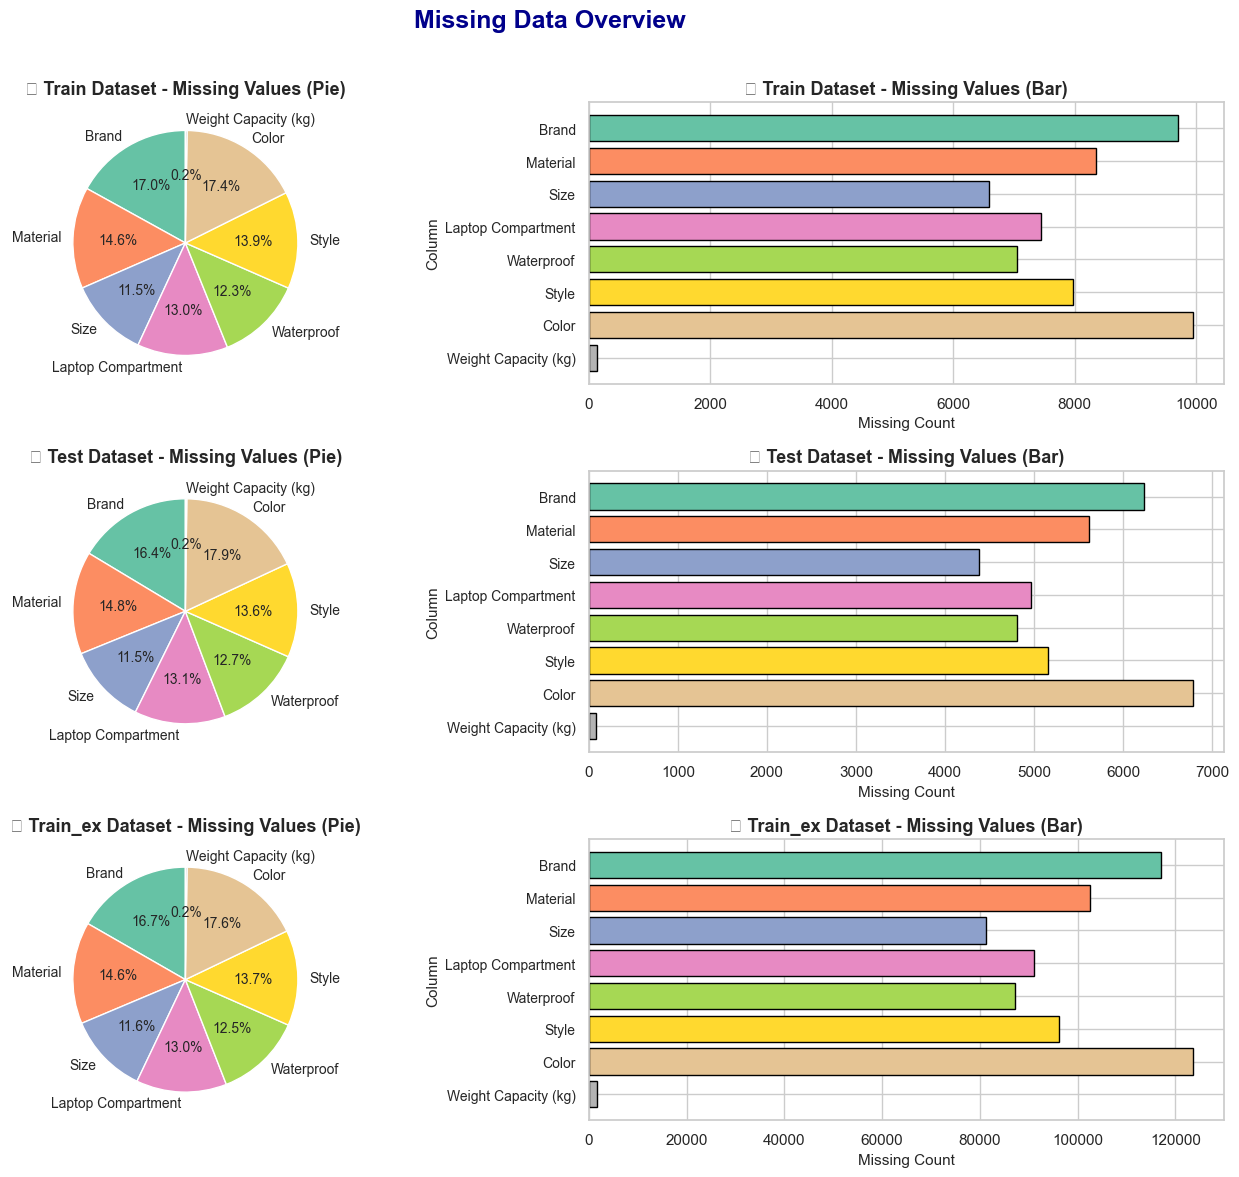

In [69]:
import warnings
warnings.filterwarnings("ignore")
custom_palette = sns.color_palette("Set2", 8)  
custom_palette_hex = custom_palette.as_hex()

# Calculate missing values
train_null = train.isnull().sum()
test_null = test.isnull().sum()
train_extra_null = train_extra.isnull().sum()

# Filter only columns with missing values
train_null = train_null[train_null > 0]
test_null = test_null[test_null > 0]
train_extra_null = train_extra_null[train_extra_null > 0]

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("Missing Data Overview", fontsize=18, fontweight='bold', color='darkblue')

datasets = [('Train', train_null), ('Test', test_null), ('Train_ex', train_extra_null)]

for i, (name, null_data) in enumerate(datasets):
    pie_ax = axes[i, 0]
    bar_ax = axes[i, 1]
    
    color_slice = custom_palette_hex[:len(null_data)]  # match number of categories

    # Pie chart
    pie_ax.pie(null_data.values, labels=null_data.index, autopct='%1.1f%%',
               startangle=90, colors=color_slice, textprops={'fontsize': 10})
    pie_ax.set_title(f'🔸 {name} Dataset - Missing Values (Pie)', fontsize=13, fontweight='bold')
    
    # Bar chart
    bar_ax.barh(null_data.index, null_data.values, color=color_slice, edgecolor='black')
    bar_ax.set_title(f'📏 {name} Dataset - Missing Values (Bar)', fontsize=13, fontweight='bold')
    bar_ax.set_xlabel('Missing Count', fontsize=11)
    bar_ax.set_ylabel('Column', fontsize=11)
    bar_ax.tick_params(axis='y', labelsize=10)
    bar_ax.invert_yaxis()

# Improve layout spacing
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [70]:
#Merging Train and Train_extra datasets in order to get whole dataset for training 
train= pd.concat([train,train_extra],axis=0,ignore_index=True)
print('Updated Train Dataset')
train

Updated Train Dataset


Brand   Material    Size  Compartments Laptop Compartment  \
0            Jansport    Leather  Medium           7.0                Yes   
1            Jansport     Canvas   Small          10.0                Yes   
2        Under Armour    Leather   Small           2.0                Yes   
3                Nike      Nylon   Small           8.0                Yes   
4              Adidas     Canvas  Medium           1.0                Yes   
...               ...        ...     ...           ...                ...   
3994313          Nike     Canvas     NaN           3.0                Yes   
3994314          Puma    Leather   Small          10.0                Yes   
3994315      Jansport     Canvas   Large          10.0                 No   
3994316          Puma     Canvas     NaN           2.0                 No   
3994317  Under Armour  Polyester  Medium           2.0                Yes   

        Waterproof      Style  Color  Weight Capacity (kg)      Price  
0               No       Tote  Black             11.611723  112.15875  
1              Yes  Messenger  Green             27.078537   68.88056  
2               No  Messenger    Red             16.643760   39.17320  
3               No  Messenger  Green             12.937220   80.60793  
4              Yes  Messenger  Green             17.749338   86.02312  
...            ...        ...    ...                   ...        ...  
3994313        Yes  Messenger   Blue             28.098120  104.74460  
3994314        Yes       Tote   Blue             17.379531  122.39043  
3994315         No   Backpack    Red             17.037708  148.18470  
3994316         No   Backpack   Gray             28.783339   22.32269  
3994317         No   Backpack   Blue             23.076169  107.61199  

[3994318 rows x 10 columns]

In [71]:
print('Merged Train dataset info')
train.info()


Merged Train dataset info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Brand                 object 
 1   Material              object 
 2   Size                  object 
 3   Compartments          float64
 4   Laptop Compartment    object 
 5   Waterproof            object 
 6   Style                 object 
 7   Color                 object 
 8   Weight Capacity (kg)  float64
 9   Price                 float64
dtypes: float64(3), object(7)
memory usage: 304.7+ MB


In [72]:
# Make copies to avoid modifying originals
train_fe = train.copy()
test_fe = test.copy()

# Size mapping - convert to numerical
size_map = {'Small':0, 'Medium':1, 'Large':2}
train_fe['Size'] = train_fe['Size'].map(size_map).fillna(-1)
test_fe['Size'] = test_fe['Size'].map(size_map).fillna(-1)

# Boolean conversion - convert to 0/1
train_fe['Laptop Compartment'] = train_fe['Laptop Compartment'].map({'Yes':1, 'No':0}).fillna(0)
test_fe['Laptop Compartment'] = test_fe['Laptop Compartment'].map({'Yes':1, 'No':0}).fillna(0)

train_fe['Waterproof'] = train_fe['Waterproof'].map({'Yes':1, 'No':0}).fillna(0)
test_fe['Waterproof'] = test_fe['Waterproof'].map({'Yes':1, 'No':0}).fillna(0)

# Weight interactions
train_fe['Weight_per_compartment'] = train_fe['Weight Capacity (kg)'] / (train_fe['Compartments'] + 1)
test_fe['Weight_per_compartment'] = test_fe['Weight Capacity (kg)'] / (test_fe['Compartments'] + 1)

#### DATA PREPROCESSING

In [73]:
from sklearn.preprocessing import OrdinalEncoder

# Handle missing values
num_cols = train_fe.select_dtypes(include=['number']).columns.drop('Price', errors='ignore')
train_fe[num_cols] = train_fe[num_cols].fillna(train_fe[num_cols].median())
test_fe[num_cols] = test_fe[num_cols].fillna(train_fe[num_cols].median())

# Categorical encoding - only for remaining object columns
cat_cols = train_fe.select_dtypes(include=['object']).columns.tolist()
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_fe[cat_cols] = encoder.fit_transform(train_fe[cat_cols])
test_fe[cat_cols] = encoder.transform(test_fe[cat_cols])

#### MODEL TRAINING

In [74]:
train_fe.head()

Brand  Material  Size  Compartments  Laptop Compartment  Waterproof  Style  \
0    1.0       1.0   1.0           7.0                 1.0         0.0    2.0   
1    1.0       0.0   0.0          10.0                 1.0         1.0    1.0   
2    4.0       1.0   0.0           2.0                 1.0         0.0    1.0   
3    2.0       2.0   0.0           8.0                 1.0         0.0    1.0   
4    0.0       0.0   1.0           1.0                 1.0         1.0    1.0   

   Color  Weight Capacity (kg)      Price  Weight_per_compartment  
0    0.0             11.611723  112.15875                1.451465  
1    3.0             27.078537   68.88056                2.461685  
2    5.0             16.643760   39.17320                5.547920  
3    3.0             12.937220   80.60793                1.437469  
4    3.0             17.749338   86.02312                8.874669

In [75]:
test_fe.head()

Brand  Material  Size  Compartments  Laptop Compartment  Waterproof  \
id                                                                            
300000    3.0       1.0   0.0           2.0                 0.0         0.0   
300001    2.0       0.0   1.0           7.0                 0.0         1.0   
300002    0.0       0.0   2.0           9.0                 0.0         1.0   
300003    0.0       2.0   2.0           1.0                 1.0         0.0   
300004    NaN       2.0   2.0           2.0                 1.0         1.0   

        Style  Color  Weight Capacity (kg)  Weight_per_compartment  
id                                                                  
300000    2.0    3.0             20.671147                6.890382  
300001    0.0    3.0             13.564105                1.695513  
300002    1.0    1.0             11.809799                1.180980  
300003    1.0    3.0             18.477036                9.238518  
300004    2.0    0.0              9.907953                3.302651

In [76]:
 #Prepare data - ensure all columns are numerical
import lightgbm as lgb

features = [c for c in train_fe.columns if c != 'Price']
X = train_fe[features].astype('float32')  # Explicit type conversion
y = train_fe['Price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify all dtypes are numerical
print("\nFinal feature dtypes:")
print(X_train.dtypes)

# Train model
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 63,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'device': 'gpu'
}

model = lgb.train(
    params,
    lgb.Dataset(X_train, label=y_train),
    num_boost_round=1000,
    valid_sets=[lgb.Dataset(X_val, y_val)],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)]
)

# Evaluate
val_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print(f"\nValidation RMSE: {rmse:.4f}")


Final feature dtypes:
Brand                     float32
Material                  float32
Size                      float32
Compartments              float32
Laptop Compartment        float32
Waterproof                float32
Style                     float32
Color                     float32
Weight Capacity (kg)      float32
Weight_per_compartment    float32
dtype: object
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 3195454, number of used features: 10
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (36.57 MB) transferred to GPU in 0.063667 secs. 0 sparse feature groups
[LightG

Let's predict using test dataset

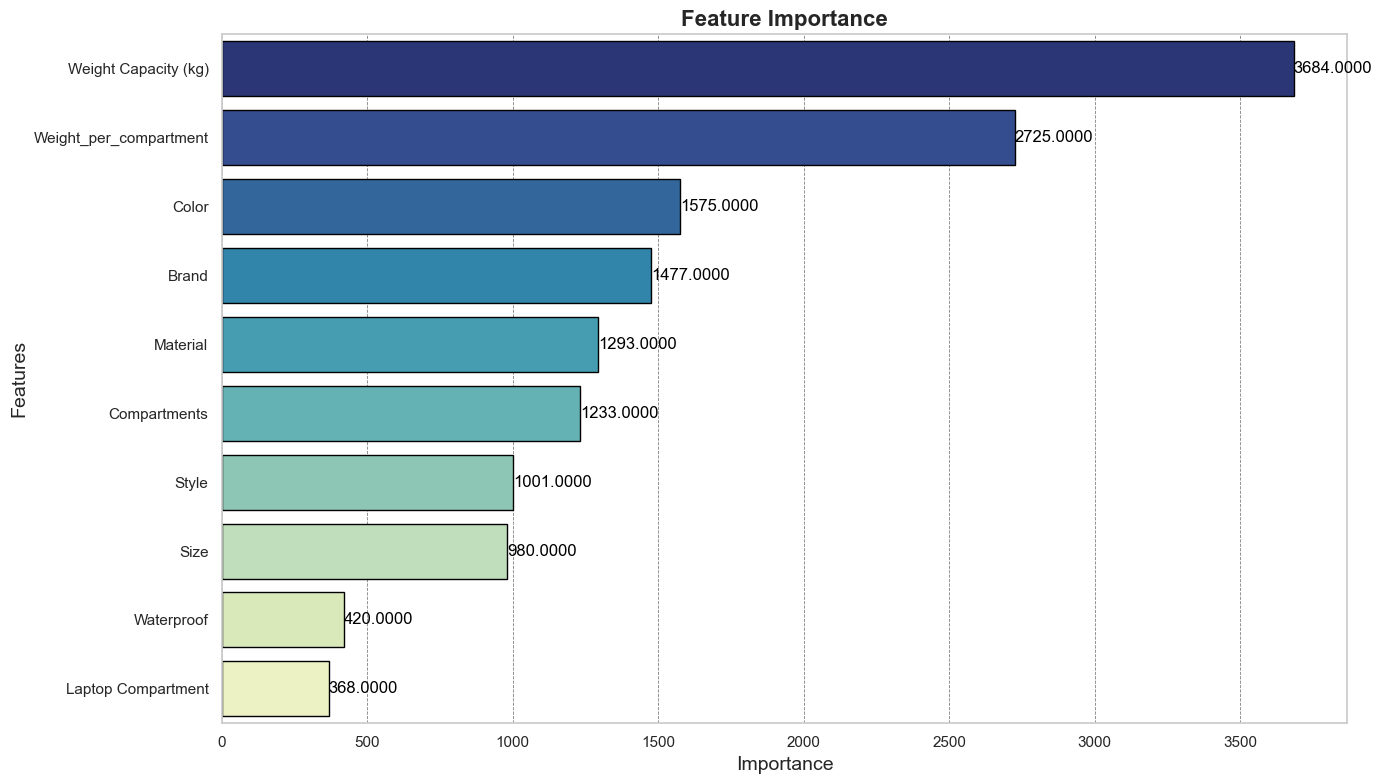

In [78]:
# Create the DataFrame for Feature Importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': model.feature_importance()})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(14, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="YlGnBu_r", edgecolor='black')
plt.title('Feature Importance', fontsize=16, weight='bold')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Add grid
plt.grid(True, color='gray', linestyle='--', linewidth=0.6, axis='x')

# Annotate each bar with its importance value
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.4f}', ha='left', va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()


In [79]:
# Prepare the test data
X_test = test_fe[features].astype('float32')  # Make sure the columns are in the same order as the training data

# Predict on the test data
test_pred = model.predict(X_test)

# Show some sample predictions
print("\nSample predictions on the test set:")
print(test_pred[:10])  # Display the first 10 predictions



Sample predictions on the test set:
[81.30329894 82.96917531 82.55711586 80.96566413 78.48953564 81.61126162
 82.84415367 84.01459348 82.9817893  79.49295215]


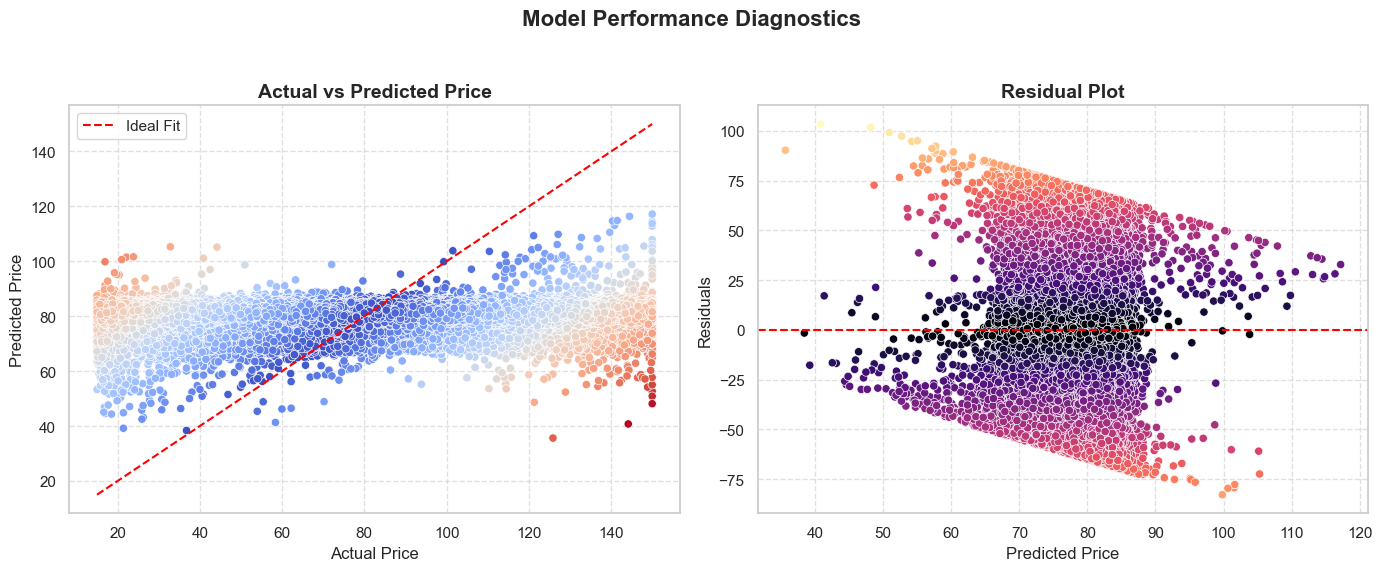

In [80]:
# Generate predictions and residuals
preds = model.predict(X_val)
residuals = y_val - preds

# Create subplots for Actual vs Predicted and Residual Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
palette = sns.color_palette("viridis", as_cmap=True)

# Actual vs Predicted Plot
sns.scatterplot(x=y_val, y=preds, hue=np.abs(residuals), palette="coolwarm", ax=axes[0], legend=False)
axes[0].plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color="red", label='Ideal Fit')
axes[0].set_xlabel("Actual Price", fontsize=12)
axes[0].set_ylabel("Predicted Price", fontsize=12)
axes[0].set_title("Actual vs Predicted Price", fontsize=14, weight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend()

# Residual Plot
sns.scatterplot(x=preds, y=residuals, hue=np.abs(residuals), palette="magma", ax=axes[1], legend=False)
axes[1].axhline(y=0, color="red", linestyle="--", lw=1.5)
axes[1].set_xlabel("Predicted Price", fontsize=12)
axes[1].set_ylabel("Residuals", fontsize=12)
axes[1].set_title("Residual Plot", fontsize=14, weight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)

# Add overall title and adjust layout
plt.suptitle("Model Performance Diagnostics", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### MODEL SAVING

In [30]:
import pickle
import json
from pathlib import Path

# Create directory if needed
Path("model_artifacts").mkdir(exist_ok=True)

# Save artifacts
with open('model_artifacts/lgbm_model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('model_artifacts/ordinal_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)
with open('model_artifacts/features.json', 'w') as f:
    json.dump(features, f)

print("\nModel artifacts saved to model_artifacts/ directory")


Model artifacts saved to model_artifacts/ directory


#### PREDICTION FUNCTION

In [81]:
def predict_price(input_data):
    """Process input and return prediction"""
    try:
        # Convert to DataFrame
        df = pd.DataFrame([input_data])
        
        # Feature engineering
        df['Size'] = df['Size'].map(size_map).fillna(-1)
        df['Weight_per_compartment'] = df['Weight Capacity (kg)'] / (df['Compartments'] + 1)
        df['Laptop Compartment'] = df['Laptop Compartment'].map({'Yes':1, 'No':0}).fillna(0)
        df['Waterproof'] = df['Waterproof'].map({'Yes':1, 'No':0}).fillna(0)
        
        # Encode categoricals
        df[cat_cols] = encoder.transform(df[cat_cols])
        
        # Ensure correct dtypes and features
        df = df[features].astype('float32')
        for f in features:
            if f not in df.columns:
                df[f] = 0  # Default for missing features
                
        return float(model.predict(df)[0])
    
    except Exception as e:
        print(f"Prediction error: {str(e)}")
        return None

# Example usage
sample_input = {
    'Brand': 'Nike',
    'Material': 'Polyester',
    'Size': 'Medium',
    'Compartments': 3,
    'Laptop Compartment': 'Yes',
    'Waterproof': 'No',
    'Style': 'Backpack',
    'Color': 'Black',
    'Weight Capacity (kg)': 12.5
}

print(f"\nSample prediction: ${predict_price(sample_input):.2f}")


Sample prediction: $79.14
